In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output
from scipy.spatial.transform import Rotation as R
import time
from scipy import stats

In [181]:
!git push

To https://github.com/olafnekeman/rotor_wake_aerodynamics.git
   2eb8eae..6013d1f  master -> master


In [2]:
#function to calculate the induction in coorp of a vortex with strength gamma located in coorv
def calc_ind(gamma,coorp,coorv):
    #calculate the distance between point v and p
    r = np.linalg.norm(coorp-coorv)
    #prevent dividing by zero
    if r == 0:
        ind = np.array([0,0])
    else:
        index_mat = np.array([[0,1],
                              [-1,0]])
        ind = gamma/(2*np.pi*r**2)*np.matmul(index_mat,coorp-coorv)
    return ind    

#function to calculate the induction in coorp of a vortex with strength gamma located in coorv
def calc_ind_field(gamma,coorp_x, coorp_z ,coorv):
    # calculate the distance between field and vorticity point
    # only x and z coordinates
    x_dist = coorp_x-coorv[0]
    z_dist = coorp_z-coorv[2]
    r = np.sqrt(np.square(x_dist)+ np.square(z_dist))
    min_core_dist=5e-3
    # reduce velocity field to zero when to close to viscous core
    # done to eliminate extreme values due to the division by r in the induced velocity equation
    r[r<min_core_dist] = 1000

    ind_x = gamma/(2*np.pi*r**2)*z_dist
    ind_z = gamma/(2*np.pi*r**2)*-x_dist
    return ind_x, ind_z 

#function to transform coordinates in the airfoil coordinate system to the
#intertial frame of reference
def transform_coords(theta,x,z,X0,Z0):
    #note that theta, X0 and Z0 are vectors of the pitch and location of the airfoil coordinate system in time
    #and x and z are vectors of coordinates in the airfoil coordinate system
    X = np.zeros([len(x),len(theta)])
    Z = np.zeros([len(x),len(theta)])
    for i in range(len(x)):
        X[i,:] = np.cos(theta)*x[i]+np.sin(theta)*z[i]+X0
        Z[i,:] = -np.sin(theta)*x[i]+np.cos(theta)*z[i]+Z0
    return X,Z

#transform the velocity of the airfoil coordinate system to a velocity induced in the airfoil coordinate system
def transform_vel(theta,X0dot,Z0dot):
    Ut = -np.cos(theta)*X0dot+np.sin(theta)*Z0dot
    Wt = -np.sin(theta)*X0dot-np.cos(theta)*Z0dot
    return Ut,Wt

    

In [117]:
#class to calculate the unsteady problem
"""
abbreviations:
- ACS            Airfoil Coordinate System
- IFR            Inertial Frame of Reference
- TE             Trailing Edge
- LE             Leading Edge
- ISA            International Standard Atmosphere

Inputs:
- x_panels       x-coordinates that describe the panels in the ACS
- z_panels       z-coordinates that describe the panels in the ACS
- time_range     time vector of the simulation, should be equally spaced
- X0             vector of the X-location of the ACS in the IFR, should be the same size as time_range
- Z0             vector of the Z-location of the ACS in the IFR, should be the same size as time_range
- theta          vector of the pitch angle of the ACS in the IFR in radians, should be the same size as time_range
- X0dot          vector of the X-velocity of the ACS in the IFR, should be the same size as time_range
- Z0dot          vector of the Z-velocity of the ACS in the IFR, should be the same size as time_range
- thetadot       vector of the pitch angle of the ACS in the IFR in radians/s, should be the same size as time_range

Functions:
- __init__                 solves the system
- find_induction_time      find the induction of the all the vortices present in the domain in coorp at time index it
                           Input: coorp (it (time index of the simulation) and array with [X,Z])
                           Optional input: include_distribution (True or False), if False returns the individual 
                                           contributions of the airfoil, shed and trailing vortices
- calculate_lift           Calculate the pressure difference and lift over the plate, saves results in attribute
                           Input: rho (density of the air)
"""

class unsteady_panel:
    def __init__(self,x_panels,z_panels,time_range,X0,Z0,theta,X0dot,Z0dot,thetadot, N_chords, N_discr, k=0, print_progress=True):
        #initialize parameters
        self.print_progress = print_progress
        N_panels = len(x_panels)-1
        dt = time_range[1]-time_range[0]
        
        self.N_panels = N_panels
        self.dt = dt
        self.x_panels = x_panels
        self.z_panels = z_panels
        self.time_range = time_range
        self.X0 = X0
        self.Z0 = Z0
        self.theta = theta
        self.X0dot = X0dot
        self.Z0dot = Z0dot
        self.thetadot = thetadot
        self.k = k
        # initialize coordinates of vortices and collocation points in the ACS
        self.x_vort = np.zeros(N_panels)
        self.z_vort = np.zeros(N_panels)
        self.x_cp = np.zeros(N_panels)
        self.z_cp = np.zeros(N_panels)
        
        # intialize an array to store the length of the panels
        self.l_panels = np.zeros(N_panels)
        
        # initialze normal vector in x-z plane
        n_cp_x = np.zeros(N_panels)
        n_cp_z = np.zeros(N_panels)
        tau_cp_x = np.zeros(N_panels)
        tau_cp_z = np.zeros(N_panels)
        
        #############################################
        # Olaf: 
        # initialize coordinate field IFR stuck to the airfoil
        chord = x_panels[-1]-x_panels[0]
        width = N_chords # width of coordinate field in number of chord length
        height = N_chords # height of coordinate field in number of chord length
        nx = N_discr # discretization in x
        ny = N_discr # discretization in y
        
        # the leading edge of the panel is always at (0,0),
        # so the x coordinates: left=(width-1)/2*chord, right=(width+1)/2*chord
        # and the y coordinates: top=width/2*chord, bottom=-width/2*chord

        # initialize coordinate field in direction of IFR and stuck to airfoil frame
        self.field_x = np.linspace(-(width-1)/2*chord, (width+1)/2*chord, nx)
        self.field_y = np.linspace(height/2*chord, -height/2*chord, ny)
        self.field = np.meshgrid(self.field_x, self.field_y)

        ######### End of 
        
        #fill the above vectors
        for i in range(N_panels):
            #position the vortex at 0.25 of the panel and the collocation point to 0.75
            self.x_vort[i] = (x_panels[i]+0.25*(x_panels[i+1]-x_panels[i]))
            self.z_vort[i] = (z_panels[i]+0.25*(z_panels[i+1]-z_panels[i]))
            self.x_cp[i] = (x_panels[i]+0.75*(x_panels[i+1]-x_panels[i]))
            self.z_cp[i] = (z_panels[i]+0.75*(z_panels[i+1]-z_panels[i]))
            
            #calculate the length of the panels
            self.l_panels[i] = np.linalg.norm(np.array([self.x_panels[i+1],self.z_panels[i+1]])-np.array([self.x_panels[i],self.z_panels[i]]))
            alpha_temp = np.arctan((z_panels[i+1]-z_panels[i])/(x_panels[i+1]-x_panels[i]))
            
            #calculate the normal and tangential vectors
            n_cp_x[i] = -np.sin(alpha_temp)
            n_cp_z[i] = np.cos(alpha_temp)
            tau_cp_x[i] = np.cos(alpha_temp)
            tau_cp_z[i] = np.sin(alpha_temp)
        
        #transform the panel coordinates, bound vorticity coordinates and collocation point coodinates to inertial frame of reference
        self.X_panels,self.Z_panels = transform_coords(theta,x_panels,z_panels,X0,Z0)
        self.X_vort,self.Z_vort = transform_coords(theta,self.x_vort,self.z_vort,X0,Z0)
        self.X_cp,self.Z_cp = transform_coords(theta,self.x_cp,self.z_cp,X0,Z0)

        #transform the normal vector to the inertial frame of reference
        N_cp_x,N_cp_z = transform_coords(theta,n_cp_x,n_cp_z,0,0)
        tau_cp_X, tau_cp_Z = transform_coords(theta,tau_cp_x,tau_cp_z,0,0)
        self.N_cp_x,self.N_cp_z = N_cp_x,N_cp_z
        
        #save them all into an attribute for later use
        self.tau_cp_x = tau_cp_x
        self.tau_cp_z = tau_cp_z
        self.tau_cp_X = tau_cp_X
        self.tau_cp_Z = tau_cp_Z
        
        #transform the velocity in the inertial frame of reference in the airfoil coordinate system
        Ut_range,Wt_range = transform_vel(theta,X0dot,Z0dot)
        self.Ut_range = Ut_range
        self.Wt_range = Wt_range
        
        #calculate the self induction from the bound vortices in the collocation points, note that the wake vorticity contributions
        #remain at zero, as these should change each timestep
        A = np.zeros([N_panels+1,N_panels+1])
        
        for i in range(N_panels):
            for j in range(N_panels):
                #calculate the normal induction due to a vortex of unit strenght from panel j on the 
                #collocation point of panel i
                coorp = np.array([self.x_cp[i],self.z_cp[i]])
                coorv = np.array([self.x_vort[j],self.z_vort[j]])
                u_ind = calc_ind(1,coorp,coorv)
                #add the result to the corresponding entry in matrix A
                A[i,j] = np.dot(u_ind,np.array([n_cp_x[i],n_cp_z[i]]))
        
        #fill the final row of matrix A with ones, corresponding to the Helmholtz condition
        A[-1,:] = np.ones(N_panels+1)
        
        #initialize the resulting vortices in the wake and their locations
        self.gamma_wake = np.zeros(len(time_range))
        
        #the row indeces in the locations correspond to the same index in the above gamma_wake vector
        #the columns correspond to the time variation. Thus the vortex strength shed by the 2nd timestep 
        #can be found in self.gamma_wake[1] and it's corresponding X-location at time t = t[it] in 
        #X[1,it]. Note, these coordinates are in the IFR
        
        self.wake_loc_X = np.zeros([len(time_range),len(time_range)])
        self.wake_loc_Z = np.zeros([len(time_range),len(time_range)])
        
        #artificially add the location of the vortex with zero strength shed in the first timestep to be equal 
        #to one for plotting purposes
        self.wake_loc_X[0,0] = 1.0 
        
        #initialize the right-hand side vector
        RHS = np.zeros([N_panels+1,1])
        
        #initialize the vector with locations of the vortex directly behind the TE in time
        self.Xcoorw1 = np.zeros(len(time_range))
        self.Zcoorw1 = np.zeros(len(time_range))
        
        #initialize the results of the vorticity of each panel in time. The j-th row corresponds to the 
        #j-th panel from the LE. Note that the final index, is not the vortex of a panel, but the one
        #that is trailing directly behind the airfoil in this timestep, of which the location can be found
        #in the above self.Xcoorw1 and self.Zcoorw1
        self.gamma_airfoil = np.zeros([N_panels+1,len(time_range)])

        for it in range(1,len(time_range)):
            #print progress, note becomes slower each timestep due to increasing size of wake
            if self.print_progress:
                clear_output(wait=True)
                print('Solving the system: {}%'.format(np.round(it/len(time_range)*100),1))
            """
            Finish matrix A for this timestep
            """
            #first find the coordinates of the shedded vortex
            #vortex trails 0.2x distance covered by the TE of the airfoil
            self.Xcoorw1[it] = (self.X_panels[-1,it]-0.2*(self.X_panels[-1,it]-self.X_panels[-1,it-1]))
            self.Zcoorw1[it] = (self.Z_panels[-1,it]-0.2*(self.Z_panels[-1,it]-self.Z_panels[-1,it-1]))
            
            #if we are in the first timestep, add also the first wake location for plotting purposes
            if it == 1:
                self.wake_loc_X[0,it] = self.Xcoorw1[it]
                self.wake_loc_Z[0,it] = self.Zcoorw1[it]
            
            #calculate the final column values of the matrix A for this timestep
            #that is, the influence of the vortex trailing behind on each collocation point
            for i in range(0,N_panels):
                coorp = np.array([self.X_cp[i,it],self.Z_cp[i,it]])
                coorv = np.array([self.Xcoorw1[it],self.Zcoorw1[it]])
                uind = calc_ind(1,coorp,coorv)
                A[i,-1] = np.dot(uind,np.array([N_cp_x[i,it],N_cp_z[i,it]]))

            """
            Calculate the RHS
            """
            for i in range(N_panels):
                #calculate the induction from the wake into each cp
                #to speed up the code, only consider the vortices that have been shed
                indeces = np.arange(0,it,dtype=int)
                gamma_temp = self.gamma_wake[indeces]
                wake_loc_X_temp = self.wake_loc_X[:,it][indeces]
                wake_loc_Z_temp = self.wake_loc_Z[:,it][indeces]

                #note, these wake velocities are defined in the IFR and not in the ACS
                u_w = 0
                w_w = 0
                coorp = np.array([self.X_cp[i,it],self.Z_cp[i,it]])
                
                #run through each vortex in the wake and add the contribution
                for j in range(len(gamma_temp)):
                    coorv = np.array([wake_loc_X_temp[j],wake_loc_Z_temp[j]])
                    uind = calc_ind(gamma_temp[j],coorp,coorv)
                    u_w += uind[0]
                    w_w += uind[1]
                 
                #calculate the effect of the kinematics. Note, these are in the airfoil coordinate system
                Ut = Ut_range[it]-thetadot[it]*self.z_cp[i]
                #deta/dt (or in this case dz/dt) is zero, the airfoil camber does not change in time
                Wt = Wt_range[it]+thetadot[it]*self.x_cp[i]
                #note again that one is defined in ACS, and one in IFR, meaning that they both use a different normal vector.
                RHS[i] = -np.dot(np.array([Ut,Wt]),np.array([n_cp_x[i],n_cp_z[i]]))-np.dot(np.array([u_w,w_w]),np.array([N_cp_x[i,it],N_cp_z[i,it]]))
            
            #finish the final entry in the RHS vector by summing the airfoil vorticity of the last timestep
            RHS[-1] = np.sum(self.gamma_airfoil[:-1,it-1])

            #solve the system of equations
            Ainv = np.linalg.inv(A)   
            self.gamma_airfoil[:,it] = np.matmul(Ainv,RHS).flatten()

            #update the wake geometries for the new time step, except of course for the final timestep
            if it!= len(time_range)-1:
                #calculate the induction of all the vortices of the i-th vortex in the wake and update the i-th location
                for i in range(it):
                    coorp = np.array([self.wake_loc_X[i,it],self.wake_loc_Z[i,it]])
                    u_ind_wake,w_ind_wake = self.find_induction_time(it,coorp)
                    self.wake_loc_X[i,it+1] = self.wake_loc_X[i,it] + u_ind_wake*dt
                    self.wake_loc_Z[i,it+1] = self.wake_loc_Z[i,it] + w_ind_wake*dt
                    
                #calculate the induction on the vortex shed in this timestep to calculate it's position in the next 
                coorp = np.array([self.Xcoorw1[it],self.Zcoorw1[it]])
                u_ind_shed,w_ind_shed = self.find_induction_time(it,coorp)
                self.wake_loc_X[it, it+1] = self.Xcoorw1[it] + u_ind_shed*dt
                self.wake_loc_Z[it, it+1] = self.Zcoorw1[it] + w_ind_shed*dt
            
            #shed the vortex in the wake
            self.gamma_wake[it] = np.sum(self.gamma_airfoil[-1,it])
    
    def find_induction_time(self,it,coorp,include_distribution=False):
        #create parameters to store the induction in 
        u_ind_wake = 0
        w_ind_wake = 0
        #calculate the induction due to the vortices of the airfoil
        for j in range(N_panels):
            coorv = np.array([self.X_vort[j,it],self.Z_vort[j,it]])
            uind = calc_ind(self.gamma_airfoil[j,it],coorp,coorv)
            u_ind_wake += uind[0]
            w_ind_wake += uind[1]
        
        #if include distribution, save these separatly and reset parameters, if not continue
        if include_distribution:
            u_ind_airfoil = 1*u_ind_wake
            w_ind_airfoil = 1*w_ind_wake
            u_ind_wake = 0
            w_ind_wake = 0
            
        #calculate the induction of the vortex shed by the airfoil
        coorv = np.array([self.Xcoorw1[it],self.Zcoorw1[it]])
        uind = calc_ind(self.gamma_airfoil[-1,it],coorp,coorv)
        u_ind_wake += uind[0]
        w_ind_wake += uind[1]
        
        #if include distribution, save these separatly and reset parameters, if not continue
        if include_distribution:
            u_ind_shed = 1*u_ind_wake
            w_ind_shed = 1*w_ind_wake
            u_ind_wake = 0
            w_ind_wake = 0

        #calculate the induction of the shed vortices on the coordinate
        for j in range(it):
            coorv = np.array([self.wake_loc_X[j,it],self.wake_loc_Z[j,it]])
            uind = calc_ind(self.gamma_wake[j],coorp,coorv)
            u_ind_wake += uind[0]
            w_ind_wake += uind[1]
        
        #if include distribution, save these separatly and reset parameters, if not continue
        if include_distribution:
            u_ind_trail = 1*u_ind_wake
            w_ind_trail = 1*w_ind_wake
            u_ind_wake = 0
            w_ind_wake = 0
        
        #if include distribution, return each induction separatly
        if include_distribution:
            return np.array([u_ind_airfoil,w_ind_airfoil]),np.array([u_ind_shed,w_ind_shed]),np.array([u_ind_trail,w_ind_trail])
        else:   
            return u_ind_wake,w_ind_wake
    
    def calculate_lift(self,rho):
        #initialize the pressure difference on the airfoil
        #rows correspond to panels and columns to time
        delta_p = np.zeros([self.N_panels,len(self.time_range)])
        
        #initialize the lift force in time
        L = np.zeros(len(self.time_range))
        
        #for every timestep, calculate the result
        for it in range(len(self.time_range)):
            #update progress
            if self.print_progress:
                clear_output(wait=True)
                print('Calculating the lift and pressure forces on the airfoil: {}%'.format(np.round(100*it/(len(self.time_range)-1),2)))

            for j in range(self.N_panels):
                #calculate the induction of the domain in the collocation point
                coorp = np.array([self.X_cp[j,it],self.Z_cp[j,it]])
                u_ind_wake,w_ind_wake = self.find_induction_time(it,coorp)
                
                #calculate the induction due to the kinematics in the collocation point
                #note, these are in the airfoil coordinate system
                Ut = self.Ut_range[it]-self.thetadot[it]*self.z_cp[j]
                #deta/dt (or in this case dz/dt) is zero, the airfoil camber does not change in time
                Wt = self.Wt_range[it]+self.thetadot[it]*self.x_cp[j]
                
                #calculate the tangential component on the current panel
                tan_comp = np.dot(np.array([Ut,Wt]),np.array([self.tau_cp_x[j],self.tau_cp_z[j]]))+np.dot(np.array([u_ind_wake,w_ind_wake]),np.array([self.tau_cp_X[j,it],self.tau_cp_Z[j,it]]))
                
                #calculate the derivative of the flow potential in time, use a central difference scheme if not the final
                #timestep
                deriv_min = np.sum(self.gamma_airfoil[:j,it-1])
                if it == 0:
                    deriv = 0
                elif it == len(time_range)-1:
                    deriv = (np.sum(self.gamma_airfoil[:j,it])-deriv_min)/dt
                else:
                    deriv_plus = np.sum(self.gamma_airfoil[:j,it+1])
                    deriv = (deriv_plus-deriv_min)/(2*dt)
                #calculate the pressure difference on the panel
                delta_p[j,it] = rho*(tan_comp*self.gamma_airfoil[j,it]/self.l_panels[j]+deriv)
                
                #calculate the resulting contribution on the lift force for the current timestep
                alpha_temp = np.arctan((self.z_panels[j+1]-self.z_panels[j])/(self.x_panels[j+1]-self.x_panels[j]))
                L[it] += delta_p[j,it]*self.l_panels[j]*np.cos(alpha_temp)
        
        #save the lift to an attribute as well as the pressure difference
        self.L = L
        self.delta_p = delta_p

    def calculate_velocity_field_mat(self,it, include_distribution=False):
        """ calculate the induced velocity field of the airfoil and wake vortices """
        # set field points and Uinf
        coorp_x, coorp_z =self.field
        self.Uinf = -np.diff(self.X0)[0]/self.dt
        
        # set ACR to origin (0,0) in IFR stuck to airfoil
        distance = self.X_vort[0,it] - self.X_vort[0,0]
        coorv_x = self.X_vort[:,it]-distance
        coorv_y = np.zeros(coorv_x.shape)
        coorv_z = self.Z_vort[:, it]
        coorv = np.array([coorv_x, coorv_y, coorv_z]).T

        #create parameters to store the induction in 
        u_ind_wake = np.zeros(coorp_x.shape)
        w_ind_wake = np.zeros(coorp_z.shape)

        #calculate the induction due to the vortices of the airfoil
        for j in range(N_panels):
            uind = calc_ind_field(self.gamma_airfoil[j,it],coorp_x, coorp_z, coorv[j])
            u_ind_wake += uind[0]
            w_ind_wake += uind[1]

        #if include distribution, save these separatly and reset parameters, if not continue
        if include_distribution:
            u_ind_airfoil = 1*u_ind_wake
            w_ind_airfoil = 1*w_ind_wake
            u_ind_wake = 0
            w_ind_wake = 0

        #calculate the induction of the vortex shed by the airfoil
        coorv = np.array([self.Xcoorw1[it]-distance,0, self.Zcoorw1[it]])
        uind = calc_ind_field(self.gamma_airfoil[-1,it],coorp_x, coorp_z, coorv)
        u_ind_wake += uind[0]
        w_ind_wake += uind[1]

        #if include distribution, save these separatly and reset parameters, if not continue
        if include_distribution:
            u_ind_shed = 1*u_ind_wake
            w_ind_shed = 1*w_ind_wake
            u_ind_wake = 0
            w_ind_wake = 0

        # set the wake_loc_x to origin (0,0) in IFR stuck to airfoil
        coorv_x = self.wake_loc_X[:,it]-distance
        coorv_x[-1] = coorv_x[-2]+np.diff(coorv_x)[-2]
        coorv_y = np.zeros(coorv_x.shape)
        coorv_z = self.wake_loc_Z[:,it]
        coorv = np.array([coorv_x, coorv_y, coorv_z]).T
        
        #calculate the induction of the shed vortices on the coordinate
        for j in range(len(self.gamma_wake)):
            uind = calc_ind_field(self.gamma_wake[j],coorp_x, coorp_z, coorv[j])
            u_ind_wake += uind[0]
            w_ind_wake += uind[1]

        #if include distribution, save these separatly and reset parameters, if not continue
        if include_distribution:
            u_ind_trail = 1*u_ind_wake
            w_ind_trail = 1*w_ind_wake
            u_ind_wake = 0
            w_ind_wake = 0
        self.u_ind, self.w_ind = u_ind_wake, w_ind_wake
        #if include distribution, return each induction separatly
        if include_distribution:
            return np.array([u_ind_airfoil,w_ind_airfoil]),np.array([u_ind_shed,w_ind_shed]),np.array([u_ind_trail,w_ind_trail])
        else:   
            return u_ind_wake,w_ind_wake

    def calculate_pressure_field(self, rho, it=-1):
        """ calculates the pressure field """
        coorp_x, coorp_z= self.field
        p_pot = 100*10**3 # 100 kPa

        # calculate components of equation 13.23
#         del_phi2 = (self.u_ind+self.Uinf)**2 + self.w_ind**2

        # use superposition to sum up potential flow
        u_ind1, w_ind1 = self.calculate_velocity_field_mat(it-1)
        u_ind2, w_ind2 = self.calculate_velocity_field_mat(it)
        # flow potential
        x_phi1, z_phi1 = u_ind1*coorp_x, w_ind1*coorp_z
        x_phi2, z_phi2 = u_ind2*coorp_x, w_ind2*coorp_z

        deriv_x = (x_phi2-x_phi1)/dt
        deriv_z = (z_phi2-z_phi1)/dt

        deriv = np.sqrt(np.square(deriv_x)+np.square(deriv_z))

        dp = -rho*(0.5*((self.u_ind+self.Uinf)**2 + self.w_ind**2)+deriv)
        return dp
        
    def plot(self, to_plot, foil_coor, vort_coor, label='?', levels=np.array([]), fname='test'):
        """ plots a contour diagram of the matrix you put in """
        #     to_plot=np.sqrt(np.square(u_ind_wake)+np.square(w_ind_wake))
        # to_plot=self.U_field

        if len(levels)<=1:
            levels = np.linspace(np.floor(np.quantile(to_plot, 0.01)), np.ceil(np.quantile(to_plot, 0.999)), 11)
        
        fig,ax=plt.subplots(1,1, figsize=(12,12))
        h = ax.contourf(self.field_x, self.field_y, to_plot, levels=levels)
        ax.scatter(vort_coor[0], vort_coor[1], color='r', s=10)
        for i in range(0, len(foil_coor[0])):
            ax.plot(foil_coor[0][i:i+2], foil_coor[1][i:i+2], color='r', linewidth=2)

        plt.grid()
        fig.colorbar(h, label=label)
        plt.show()
        if fname != 'test':
            fig.savefig(fname)



# Airfoil at constant aoa

In [73]:
#initialize class for an airfoil at constant angle of attack
#define the airfoil in the local coordinate system
N_panels = 30
N_chords = 3
N_discr = 200

#use cosine spacing
beta_range = np.linspace(0,np.pi,N_panels+1)
x_panels = (1-np.cos(beta_range))/2
z_panels = np.zeros(N_panels+1)  #add camber function here if relevant

#define the time vector
T_max = 4*np.pi
dt = T_max/50
Uinf = 5
rho = 1.225

time_range = np.arange(0,T_max,dt)

#define movement of geometry
X0 = -Uinf*time_range
Z0 = np.zeros(len(time_range))
X0dot = -Uinf*np.ones(len(time_range))
Z0dot = np.zeros(len(time_range))
theta = 15*np.ones(len(time_range))*np.pi/180
thetadot = np.zeros(len(time_range))
# theta = 5*np.sin(5*time_range)/180*np.pi
# thetadot = 25*np.cos(5*time_range)/180*np.pi

#initialize the class
U = unsteady_panel(x_panels,z_panels,time_range,X0,Z0,theta,X0dot,Z0dot,thetadot, N_chords, N_discr)
#calculate the lift force at ISA, 0 altitude density
U.calculate_lift(rho)

Calculating the lift and pressure forces on the airfoil: 100.0%


### Animate velocity field

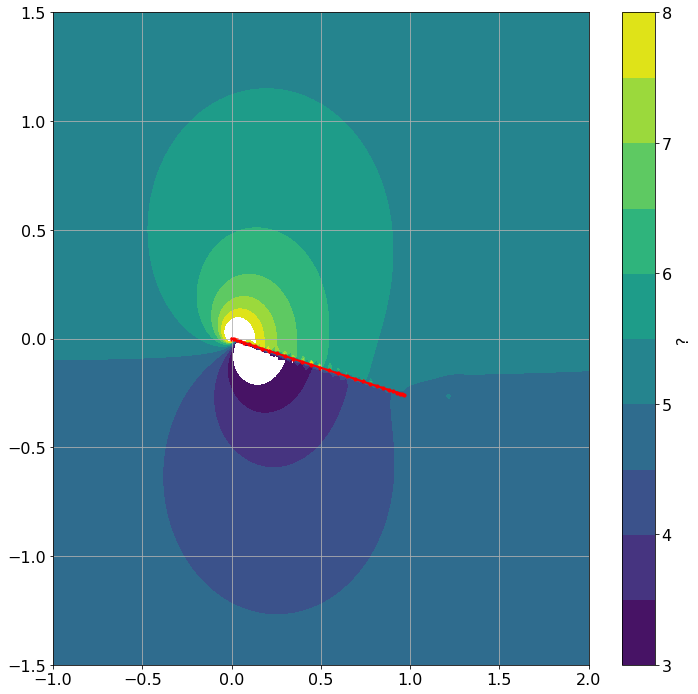

In [74]:
for i in range(len(U.time_range)):

    if i <20:
        clear_output(wait=True)
        u_ind, w_ind = U.calculate_velocity_field_mat(it=i)
        to_plot = np.sqrt((u_ind+U.Uinf)**2+w_ind**2)
        foil_coor = transform_coords(np.array([U.theta[i]]), x_panels, z_panels, 0,0)
        vort_coor = transform_coords(np.array([U.theta[i]]), U.x_vort, U.z_vort, 0,0)
        U.plot(to_plot, foil_coor, vort_coor, levels=np.linspace(3, 8, 11))
    
    time.sleep(0.2)

### Animate pressure field

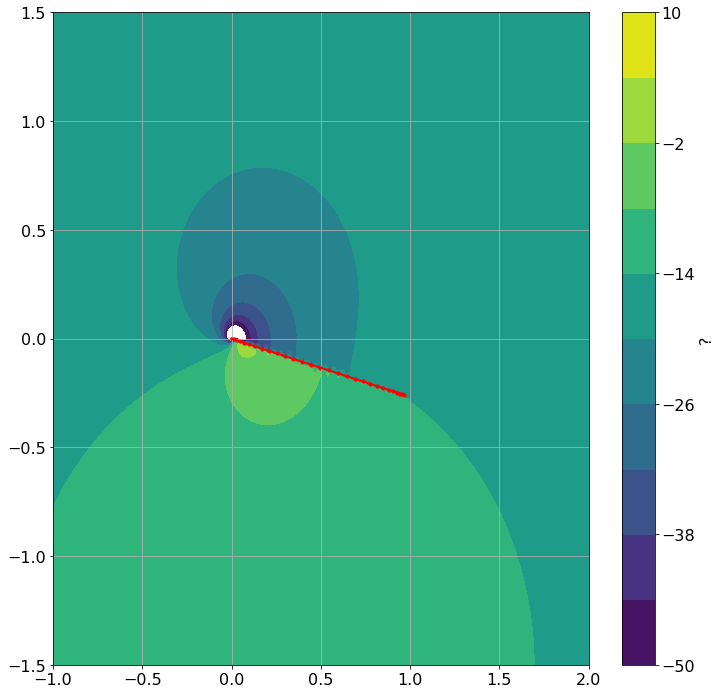

In [75]:
for i in range(len(U.time_range)):

    clear_output(wait=True)
    dp = U.calculate_pressure_field(rho, it=i)
    foil_coor = transform_coords(np.array([U.theta[i]]), x_panels, z_panels, 0,0)
    vort_coor = transform_coords(np.array([U.theta[i]]), U.x_vort, U.z_vort, 0,0)
    U.plot(dp, foil_coor, vort_coor, levels=np.linspace(-50, 10, 11))

    time.sleep(0.2)

### Plot Cl vs. alpha (BEWARE: NOTEBOOK MAY BREAK DOWN DUE THE INTENSITY OF COMPUTATIONS!)

In [24]:
import threading
N_panels = 30
# !!! increase N_div if the notebook breaks down.!!!
N_div = 6

alpha_range = np.arange(-5,15,0.2)
alpha_list = []
Cl_list = []
global Cl_list, alpha_list

def thread_run(alpha, N_panels):
    #use cosine spacing
    beta_range = np.linspace(0,np.pi,N_panels+1)
    x_panels = (1-np.cos(beta_range))/2
    z_panels = np.zeros(N_panels+1)  #add camber function here if relevant

    clear_output(wait=True)
    print('starting on alpha={}'.format(alpha))
    theta = alpha*np.ones(len(time_range))*np.pi/180
    U = unsteady_panel(x_panels,z_panels,time_range,X0,Z0,theta,X0dot,Z0dot,thetadot, N_chords, N_discr, print_progress=False)
    U.calculate_lift(rho)
    clear_output(wait=True)
    print('finished with alpha={}'.format(alpha))
    alpha_list.append(alpha)
    Cl_list.append(U.L[-1]/(0.5*rho*Uinf**2))

for i in range(N_div):
    start = int(i/N_div*len(alpha_range))
    end = int((i+1)/N_div*len(alpha_range))
    alpha_temp = alpha_range[start:end]
    threads = list()
    for alpha in alpha_temp:
        x = threading.Thread(target=thread_run, args=(round(alpha, 3), N_panels,))
        threads.append(x)
        x.start()

    for index, thread in enumerate(threads):
        thread.join()


finished with alpha=13.4


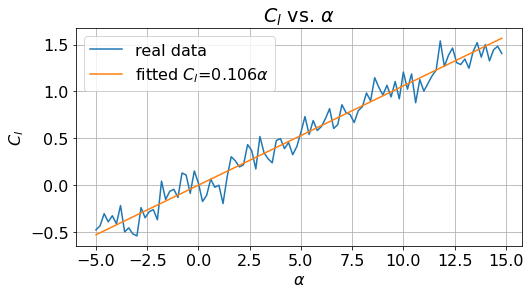

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


R2=0.9997


In [49]:
slope, intercept, r_value, p_value, std_err = stats.linregress(alpha_list, Cl_list)
Cl = slope*alpha_range+intercept

fontsize=16
fig = plt.figure(figsize=(8,4))
plt.rcParams.update({'font.size': fontsize})
plt.plot(alpha_range, Cl_list, label='real data')
plt.plot(alpha_range, Cl, label='fitted '+ r'$C_{l}$' +'={}'.format(round(slope,3))+r'$\alpha$')
plt.title(r'$C_{l}$'+' vs. '+r'$\alpha$')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$C_{l}$')
plt.legend()
plt.grid()
plt.show()
fig.savefig('constant_cl_alpha.eps')
print('R2={}'.format(round(r_value**2, 4)))

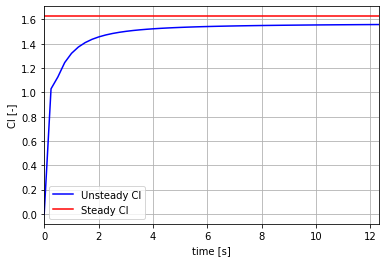

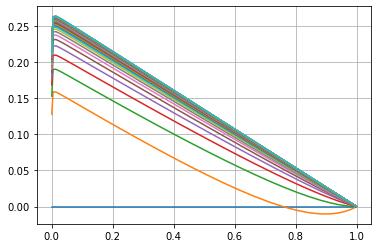

In [18]:
#transform the result to a lift coefficient
Cl = U.L/(0.5*rho*Uinf**2)

#calculate the steady state lift coefficient from analytical thin airfoil theory (i.e. flat plate)
expected_cl = 2*np.pi*np.sin(theta) * np.ones(len(time_range))


    
#plot the result
plt.figure()
plt.plot(time_range,Cl, color = 'b', label = 'Unsteady Cl')
plt.plot(time_range,expected_cl, color = 'r', label ='Steady Cl')
plt.grid(True)
plt.xlim([time_range[0],time_range[-1]])
plt.xlabel('time [s]')
plt.ylabel('Cl [-]')
plt.legend()


#plot the circulation on the airfoil
plt.figure()
for i in range(len(time_range)):
    plt.plot(U.x_vort,U.gamma_airfoil[:-1,i])
plt.grid(True)

(-17.5, 17.5)

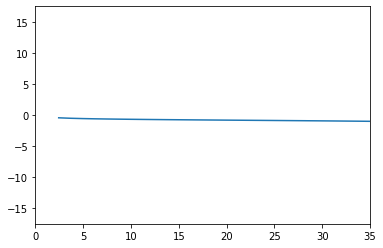

In [20]:
#plot the shape of the wake at time index it
it = -1
plt.plot(U.wake_loc_X[:it,it]-X0[it],U.wake_loc_Z[:it,it])
plt.xlim([0,35])
plt.ylim([-35/2,35/2])

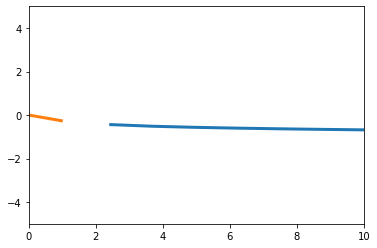

In [21]:
#create a animation of the airfoil and the wake
fig = plt.figure()
ax = plt.axes(xlim=(0,10), ylim = (-5,5))
line, = ax.plot([], [], lw=3)
airfoil, = ax.plot([],[], lw=3)

def init():
    line.set_data([],[])
    airfoil.set_data([],[])
    return line,

def animate(i):
    x = U.wake_loc_X[:i,i]-X0[i]
    y = U.wake_loc_Z[:i,i]

    line.set_data(x,y)
    
    x_airfoil = U.X_panels[:,i]-X0[i]
    y_airfoil = U.Z_panels[:,i]
    
    airfoil.set_data(x_airfoil,y_airfoil)
    
    return line,airfoil,

anim = FuncAnimation(fig, animate, init_func = init, frames=len(time_range), interval = round(T_max/len(time_range)*1000), blit = True)
# anim.save('wake_constant_alpha.gif')
anim.save('wake_constant_alpha.html', writer='html')


### Create plots over time

In [ ]:
def create_velocity_plots(self, fname=''):
    N_rows = 2
    N_cols = 4
    fontsize = 16
    N_plots = N_rows*N_cols
    fig, ax = plt.subplots(N_rows, N_cols, figsize=(18,8), sharex=True, sharey=True)

    levels = np.linspace(2.5, 7.5, 6)
    if len(levels)<=1:
        levels = np.linspace(np.floor(np.quantile(to_plot, 0.01)), np.ceil(np.quantile(to_plot, 0.999)), 11)

    for i in range(N_plots):
        # at the end of the loop, plot the last timestep
        plt.rcParams.update({'font.size': fontsize})

        if i == N_plots-1:
            i = len(time_range)-1
        title = 't={}s'.format(round(self.time_range[i], 2))

        u_ind, w_ind = self.calculate_velocity_field_mat(it=i)
        to_plot = np.sqrt((u_ind+self.Uinf)**2+w_ind**2)
        foil_coor = transform_coords(np.array([self.theta[i]]), self.x_panels, self.z_panels, 0,0)
        vort_coor = transform_coords(np.array([self.theta[i]]), self.x_vort, self.z_vort, 0,0)

        # reset at the end for plotting purposes
        if i == len(time_range)-1:
            i = N_plots-1

        # plot everything
        ax[i//N_cols, i%N_cols].set_title(title, fontsize=fontsize)
        v = ax[i//N_cols, i%N_cols].contourf(self.field_x, self.field_y, to_plot, levels=levels)
        ax[i//N_cols, i%N_cols].scatter(vort_coor[0], vort_coor[1], color='r', s=10)

        for j in range(0, len(foil_coor[0])):
            ax[i//N_cols, i%N_cols].plot(foil_coor[0][j:j+2], foil_coor[1][j:j+2], color='r', linewidth=2)

        plt.grid()
#         fig.subplots_adjust(right=12/14)
#         cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#         fig.colorbar(v, cax=cbar_ax)
    cbar = fig.colorbar(v, ax=ax.ravel().tolist(), label='m/s')
    cbar.ax.tick_params(labelsize=fontsize+4)
    fig.suptitle('Velocity distribution', fontsize=24)
    plt.show()
    if fname:
        fig.savefig(fname)
create_velocity_plots(U, fname='constant_velocity_distribution.eps')

In [ ]:

def create_pressure_plots(self, rho, levels=np.array([]), fname=''):
    N_rows = 2
    N_cols = 4
    fontsize = 16
    N_plots = N_rows*N_cols
    fig, ax = plt.subplots(N_rows, N_cols, figsize=(18,8), sharex=True, sharey=True)


    if len(levels)<=1:
        levels=np.linspace(-40, 10, 6)

    for i in range(N_plots):
        # at the end of the loop, plot the last timestep
        plt.rcParams.update({'font.size': fontsize})

        if i == N_plots-1:
            i = len(time_range)-1
        title = 't={}s'.format(round(self.time_range[i], 2))

        dp = self.calculate_pressure_field(rho, it=i)
        to_plot = dp
        foil_coor = transform_coords(np.array([self.theta[i]]), self.x_panels, self.z_panels, 0,0)
        vort_coor = transform_coords(np.array([self.theta[i]]), self.x_vort, self.z_vort, 0,0)

        # reset at the end for plotting purposes
        if i == len(time_range)-1:
            i = N_plots-1

        # plot everything
        ax[i//N_cols, i%N_cols].set_title(title, fontsize=fontsize)
        v = ax[i//N_cols, i%N_cols].contourf(self.field_x, self.field_y, to_plot, levels=levels)
        ax[i//N_cols, i%N_cols].scatter(vort_coor[0], vort_coor[1], color='r', s=10)

        for j in range(0, len(foil_coor[0])):
            ax[i//N_cols, i%N_cols].plot(foil_coor[0][j:j+2], foil_coor[1][j:j+2], color='r', linewidth=2)

        plt.grid()
#         fig.subplots_adjust(right=12/14)
#         cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#         fig.colorbar(v, cax=cbar_ax)
    cbar = fig.colorbar(v, ax=ax.ravel().tolist(), label='Pa')
    cbar.ax.tick_params(labelsize=fontsize+4)
    fig.suptitle('Pressure distribution', fontsize=24)
    plt.show()
    if fname:
        fig.savefig(fname)
create_pressure_plots(U, rho, fname='constant_pressure_distribution.eps')

# Do all the above, but then for sinusoidal change in pitch of airfoil

In [140]:
#initialize class
#define the airfoil in the local coordinate system
N_panels = 30
N_chords = 3
N_discr = 200

#use cosine spacing
beta_range = np.linspace(0,np.pi,N_panels+1)
x_panels = (1-np.cos(beta_range))/2
z_panels = np.zeros(N_panels+1)  #add camber function here if relevant

#define the time vector
T_max = 6*np.pi
dt = T_max/100
Uinf = 5
rho = 1.225

time_range = np.arange(0,T_max,dt)

#define movement of geometry
X0 = -Uinf*time_range
Z0 = np.zeros(len(time_range))
X0dot = -Uinf*np.ones(len(time_range))
Z0dot = np.zeros(len(time_range))
# theta = 5*np.ones(len(time_range))*np.pi/180
# thetadot = np.zeros(len(time_range))
k_range = [0.02 , 0.05, 0.1]
k = k_range[2]
omega = k*2*Uinf

theta = 15*np.sin(omega*time_range)/180*np.pi
thetadot = 15*omega*np.cos(omega*time_range)/180*np.pi

#initialize the class
U = unsteady_panel(x_panels,z_panels,time_range,X0,Z0,theta,X0dot,Z0dot,thetadot, N_chords, N_discr, k)
#calculate the lift force at ISA, 0 altitude density
U.calculate_lift(rho)

Calculating the lift and pressure forces on the airfoil: 100.0%


### Animate velocity field

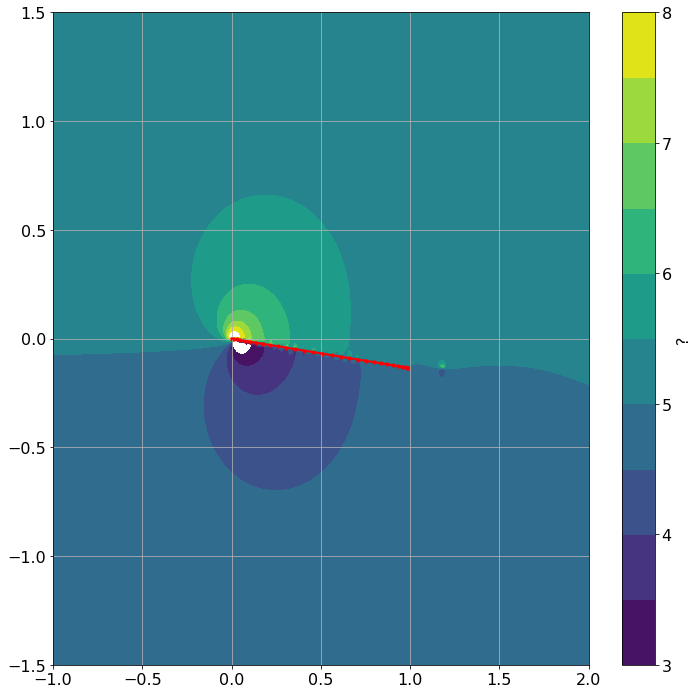

In [115]:
for i in range(len(U.time_range)-30):
    clear_output(wait=True)
    u_ind, w_ind = U.calculate_velocity_field_mat(it=i)
    to_plot = np.sqrt((u_ind+U.Uinf)**2+w_ind**2)
    foil_coor = transform_coords(np.array([U.theta[i]]), x_panels, z_panels, 0,0)
    vort_coor = transform_coords(np.array([U.theta[i]]), U.x_vort, U.z_vort, 0,0)
    U.plot(to_plot, foil_coor, vort_coor, levels=np.linspace(3, 8, 11))

    time.sleep(0.1)

### Animate pressure field

In [99]:
for i in range(len(U.time_range)):

    clear_output(wait=True)
    dp = U.calculate_pressure_field(rho, it=i)
    foil_coor = transform_coords(np.array([U.theta[i]]), x_panels, z_panels, 0,0)
    vort_coor = transform_coords(np.array([U.theta[i]]), U.x_vort, U.z_vort, 0,0)
    U.plot(dp, foil_coor, vort_coor, levels=np.linspace(0, 30, 11))

    time.sleep(0.2)

KeyboardInterrupt: 

### Plot Cl vs. alpha

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


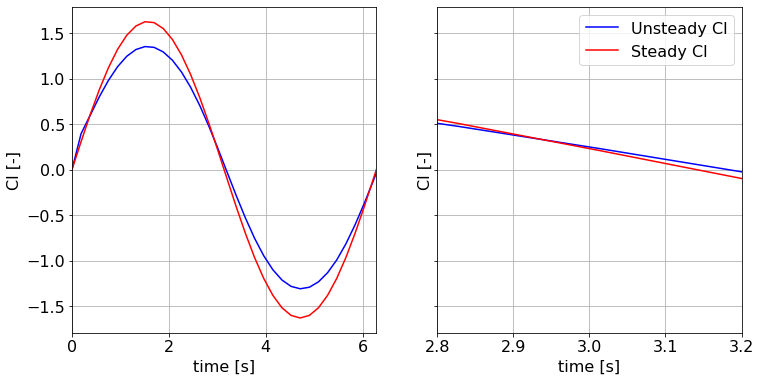

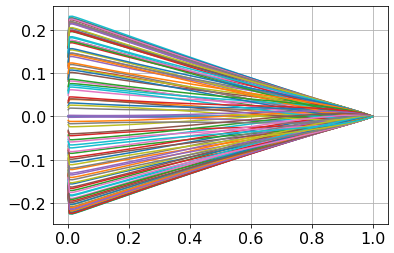

In [167]:
#transform the result to a lift coefficient
Cl = U.L/(0.5*rho*Uinf**2)

#calculate the steady state lift coefficient from analytical thin airfoil theory (i.e. flat plate)
expected_cl = 2*np.pi*np.sin(theta) 

#plot the result
fig, ax = plt.subplots(1,2, figsize=(12, 6), sharey=True)
ax[0].plot(time_range,Cl, color = 'b', label = 'Unsteady Cl')
ax[0].plot(time_range,expected_cl, color = 'r', label ='Steady Cl')
ax[0].grid(True)
ax[0].set_xlim([time_range[0],2*np.pi])
ax[0].set_xlabel('time [s]')
ax[0].set_ylabel('Cl [-]')

ax[1].plot(time_range,Cl, color = 'b', label = 'Unsteady Cl')
ax[1].plot(time_range,expected_cl, color = 'r', label ='Steady Cl')
ax[1].grid(True)
ax[1].set_xlim([time_range[0],time_range[-1]])
ax[1].set_xlabel('time [s]')
ax[1].set_ylabel('Cl [-]')
ax[1].set_xlim(left=2.8, right=3.2)
plt.legend()
fig.savefig('change_phase_delay.eps')

#plot the circulation on the airfoil
plt.figure()
for i in range(len(time_range)):
    plt.plot(U.x_vort,U.gamma_airfoil[:-1,i])
plt.grid(True)

(-17.5, 17.5)

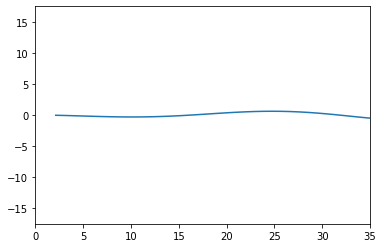

In [27]:
#plot the shape of the wake at time index it
it = 50
plt.plot(U.wake_loc_X[:it,it]-X0[it],U.wake_loc_Z[:it,it])
plt.xlim([0,35])
plt.ylim([-35/2,35/2])

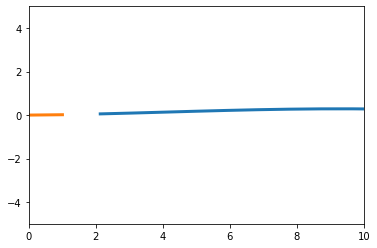

In [29]:
#create a animation of the airfoil and the wake
fig = plt.figure()
ax = plt.axes(xlim=(0,10), ylim = (-5,5))
line, = ax.plot([], [], lw=3)
airfoil, = ax.plot([],[], lw=3)

def init():
    line.set_data([],[])
    airfoil.set_data([],[])
    return line,

def animate(i):
    x = U.wake_loc_X[:i,i]-X0[i]
    y = U.wake_loc_Z[:i,i]

    line.set_data(x,y)
    
    x_airfoil = U.X_panels[:,i]-X0[i]
    y_airfoil = U.Z_panels[:,i]
    
    airfoil.set_data(x_airfoil,y_airfoil)
    
    return line,airfoil,

anim = FuncAnimation(fig, animate, init_func = init, frames=len(time_range), interval = round(T_max/len(time_range)*1000), blit = True)

# anim.save('wake_sine.gif')
anim.save('wake_sine.html', writer='html')


### Creating plots

start plotting
start plotting
start plotting
start plotting
start plotting


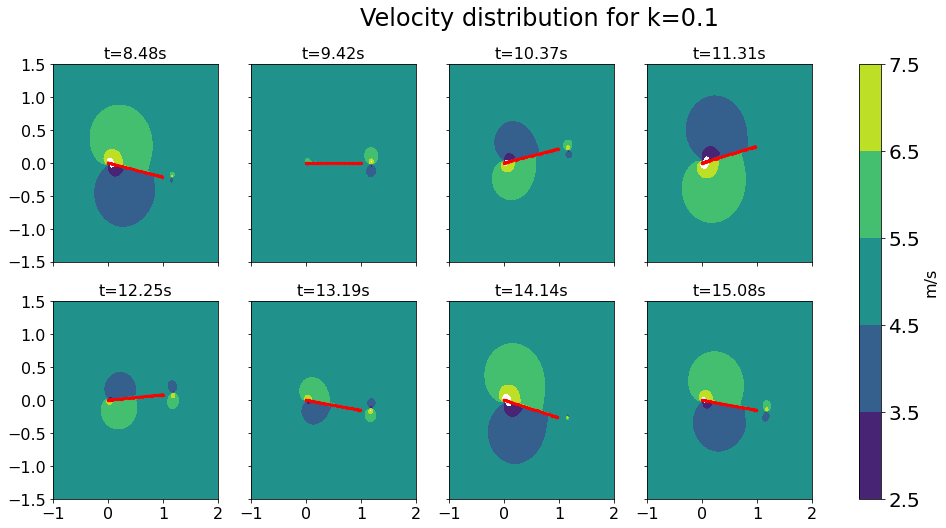

In [177]:

def create_velocity_plots(self, fname=''):
    N_rows = 2
    N_cols = 4
    fontsize = 16
    interval = 5
    N_plots = N_rows*N_cols
    fig, ax = plt.subplots(N_rows, N_cols, figsize=(18,8), sharex=True, sharey=True)

    levels = np.linspace(2.5, 7.5, 6)
    if len(levels)<=1:
        levels = np.linspace(np.floor(np.quantile(to_plot, 0.01)), np.ceil(np.quantile(to_plot, 0.999)), 11)
    min_theta = self.theta.min()
    max_theta = self.theta.max()
    start_plotting=False
    plot=0
    # start when the flow is developed
    for i in range(15, len(self.time_range)):

        # create switch when the maximum excitation is reached and stop when the plots are filled
        if round(self.theta[i], 2) == round(max_theta, 2):
            start_plotting = True
            print('start plotting')
        if plot >= N_plots:
            break
        
        # start the plotting after the switch
        if start_plotting:
            # plot per interval
            if i%interval!=0:
                continue
            plt.rcParams.update({'font.size': fontsize})
            title = 't={}s'.format(round(self.time_range[i], 2))

            u_ind, w_ind = self.calculate_velocity_field_mat(it=i)
            to_plot = np.sqrt((u_ind+self.Uinf)**2+w_ind**2)
            foil_coor = transform_coords(np.array([self.theta[i]]), self.x_panels, self.z_panels, 0,0)
            vort_coor = transform_coords(np.array([self.theta[i]]), self.x_vort, self.z_vort, 0,0)


            # plot everything
            ax[plot//N_cols, plot%N_cols].set_title(title, fontsize=fontsize)
            v = ax[plot//N_cols, plot%N_cols].contourf(self.field_x, self.field_y, to_plot, levels=levels)
            ax[plot//N_cols, plot%N_cols].scatter(vort_coor[0], vort_coor[1], color='r', s=5)

            for j in range(0, len(foil_coor[0])):
                ax[plot//N_cols, plot%N_cols].plot(foil_coor[0][j:j+2], foil_coor[1][j:j+2], color='r', linewidth=2)

            plt.grid()
            plot += 1
    fig.subplots_adjust(right=12/14)
    cbar = fig.colorbar(v, ax=ax.ravel().tolist(), label='m/s')
    cbar.ax.tick_params(labelsize=fontsize+4)
    fig.suptitle('Velocity distribution for k={}'.format(self.k), fontsize=24)
    plt.show()
    if fname:
        fig.savefig(fname)
fname = 'change_velocity_distribution_k'+ str(U.k).replace('.', '_')+'.eps'

create_velocity_plots(U, fname=fname)


start plotting
start plotting
start plotting
start plotting
start plotting


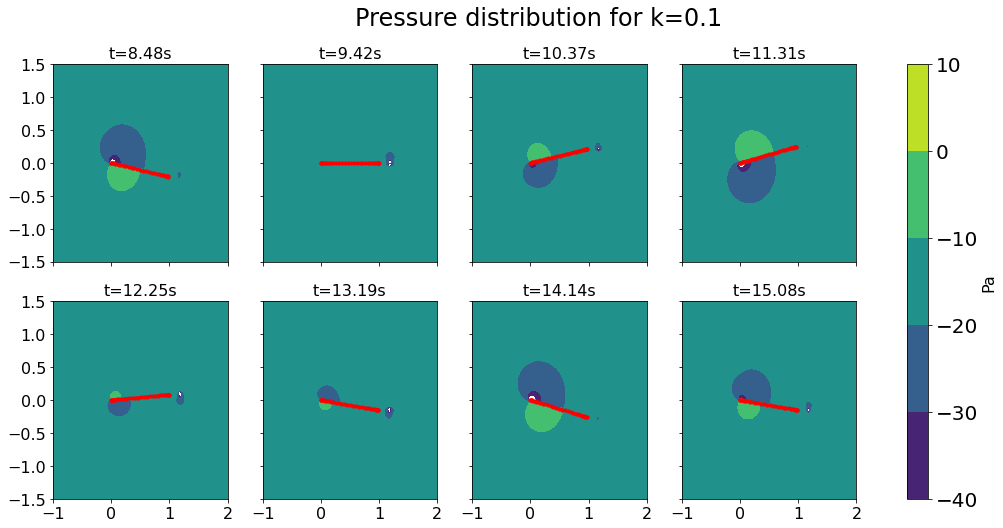

In [178]:
def create_pressure_plots(self, rho, levels=np.array([]), fname=''):
    N_rows = 2
    N_cols = 4
    fontsize = 16
    interval = 5 # set the time interval for plotting purposes
    N_plots = N_rows*N_cols
    fig, ax = plt.subplots(N_rows, N_cols, figsize=(18,8), sharex=True, sharey=True)


    if len(levels)<=1:
        levels=np.linspace(-40, 10, 6)

    min_theta = self.theta.min()
    max_theta = self.theta.max()
    start_plotting=False
    plot=0
    # start when the flow is developed
    for i in range(15, len(self.time_range)):

        # create switch when the maximum excitation is reached and stop when the plots are filled
        if round(U.theta[i], 2) == round(max_theta, 2):
            start_plotting = True
            print('start plotting')
        if plot >= N_plots:
            break
        
        # start the plotting after the switch
        if start_plotting:
            # plot per interval
            if i%interval!=0:
                continue
            plt.rcParams.update({'font.size': fontsize})
            title = 't={}s'.format(round(self.time_range[i], 2))

            dp = self.calculate_pressure_field(rho, it=i)
            to_plot = dp
            foil_coor = transform_coords(np.array([self.theta[i]]), self.x_panels, self.z_panels, 0,0)
            vort_coor = transform_coords(np.array([self.theta[i]]), self.x_vort, self.z_vort, 0,0)


            # plot everything
            ax[plot//N_cols, plot%N_cols].set_title(title, fontsize=fontsize)
            v = ax[plot//N_cols, plot%N_cols].contourf(self.field_x, self.field_y, to_plot, levels=levels)
            ax[plot//N_cols, plot%N_cols].scatter(vort_coor[0], vort_coor[1], color='r', s=10)

            for j in range(0, len(foil_coor[0])):
                ax[plot//N_cols, plot%N_cols].plot(foil_coor[0][j:j+2], foil_coor[1][j:j+2], color='r', linewidth=2)

            plt.grid()
            plot += 1
#         fig.subplots_adjust(right=12/14)
#         cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#         fig.colorbar(v, cax=cbar_ax)
    cbar = fig.colorbar(v, ax=ax.ravel().tolist(), label='Pa')
    cbar.ax.tick_params(labelsize=fontsize+4)
    fig.suptitle('Pressure distribution for k={}'.format(k), fontsize=24)
    plt.show()
    if fname:
        fig.savefig(fname)
fname = 'change_pressure_distribution_k'+ str(U.k).replace('.', '_')+'.eps'
create_pressure_plots(U, rho, levels=np.array([]), fname=fname)